# Necessary Libs

In [476]:
# System libs
import os, csv, torch, scipy.io, PIL.Image, torchvision.transforms
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import urllib.request
from tqdm import tqdm

# Download the model weights
- Model can be found at http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/

In [477]:
model_weights = 'pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/'

if not os.path.exists(model_weights):
    os.makedirs(model_weights)

# Check if folder is empty
if not os.listdir(model_weights):
    print("Folder is empty, downloading weights...")
    # Define the download function
    def download_weights(url, filename):
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, model_weights + filename, reporthook=lambda blocks, block_size, total_size: t.update(block_size))

    # Download the encoder weights
    encoder_url = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth'
    encoder_filename = 'encoder_epoch_20.pth'
    download_weights(encoder_url, encoder_filename)

    # Download the decoder weights
    decoder_url = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth'
    decoder_filename = 'decoder_epoch_20.pth'
    download_weights(decoder_url, decoder_filename)

    print("Weights downloaded successfully!")
else:
    print("Folder is not empty, skipping weight download.")


Folder is not empty, skipping weight download.


# Load colors and class names for segmentation

In [478]:
colors = scipy.io.loadmat('pretrained_seg_model/data/color150.mat')['colors']
names = {}
with open('pretrained_seg_model/data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

In [479]:
names

{1: 'wall',
 2: 'building',
 3: 'sky',
 4: 'floor',
 5: 'tree',
 6: 'ceiling',
 7: 'road',
 8: 'bed',
 9: 'windowpane',
 10: 'grass',
 11: 'cabinet',
 12: 'sidewalk',
 13: 'person',
 14: 'earth',
 15: 'door',
 16: 'table',
 17: 'mountain',
 18: 'plant',
 19: 'curtain',
 20: 'chair',
 21: 'car',
 22: 'water',
 23: 'painting',
 24: 'sofa',
 25: 'shelf',
 26: 'house',
 27: 'sea',
 28: 'mirror',
 29: 'rug',
 30: 'field',
 31: 'armchair',
 32: 'seat',
 33: 'fence',
 34: 'desk',
 35: 'rock',
 36: 'wardrobe',
 37: 'lamp',
 38: 'bathtub',
 39: 'railing',
 40: 'cushion',
 41: 'base',
 42: 'box',
 43: 'column',
 44: 'signboard',
 45: 'chest',
 46: 'counter',
 47: 'sand',
 48: 'sink',
 49: 'skyscraper',
 50: 'fireplace',
 51: 'refrigerator',
 52: 'grandstand',
 53: 'path',
 54: 'stairs',
 55: 'runway',
 56: 'case',
 57: 'pool',
 58: 'pillow',
 59: 'screen',
 60: 'stairway',
 61: 'river',
 62: 'bridge',
 63: 'bookcase',
 64: 'blind',
 65: 'coffee',
 66: 'toilet',
 67: 'flower',
 68: 'book',
 69: '

# Build Encoder-Decoder model

In [480]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cpu()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

# Visualization function

In [481]:
def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

# Load one image

In [482]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('captchas/recaptcha/rc-image-tile-44/stairs_3.png').convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cpu()}
output_size = img_data.shape[1:]

# Predict on that image

In [483]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()

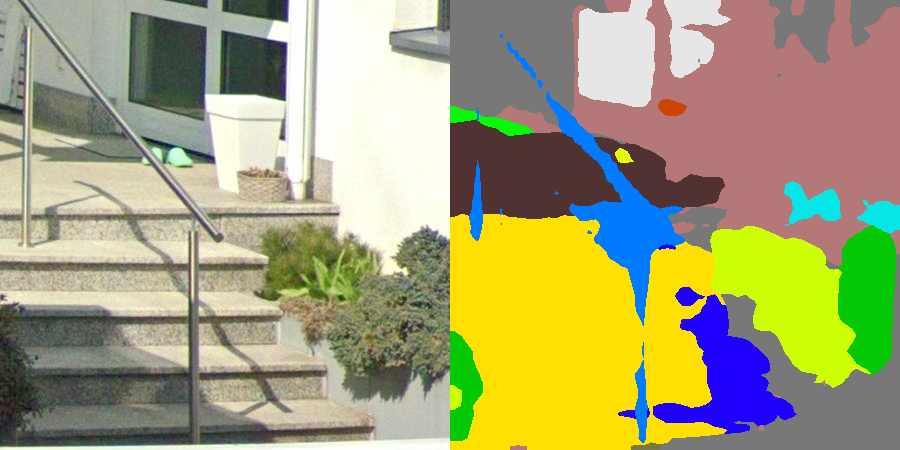

In [484]:
visualize_result(img_original, pred)

building:


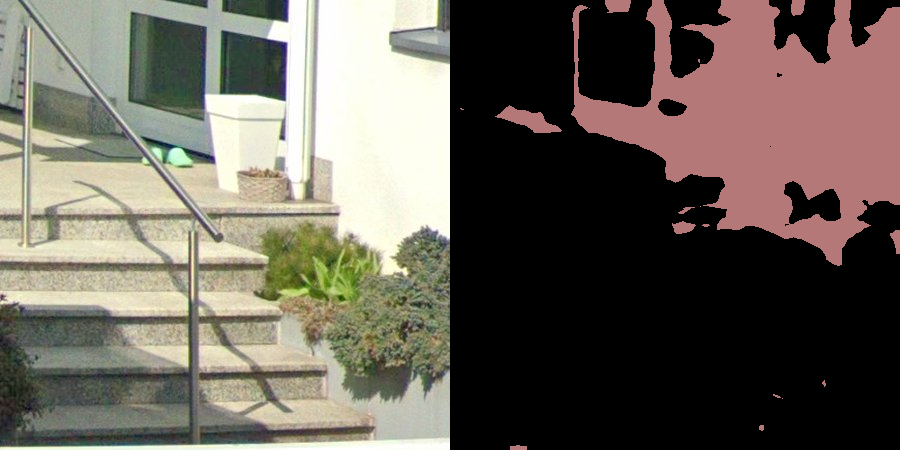

stairs:


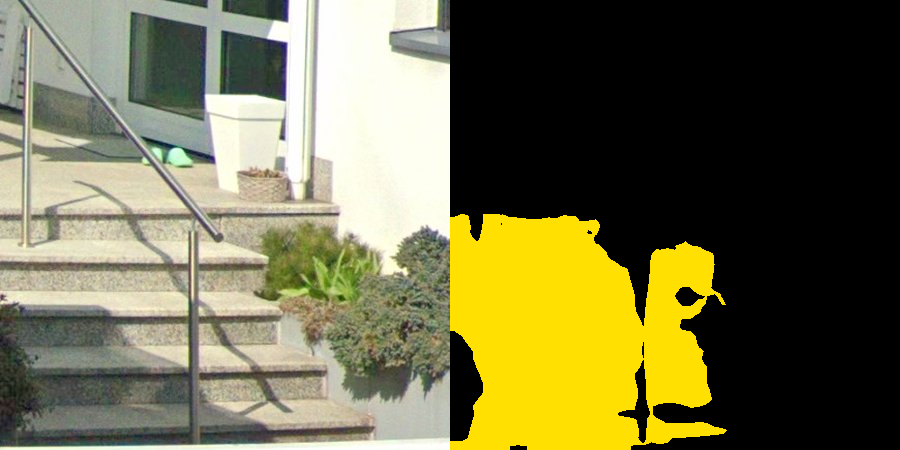

wall:


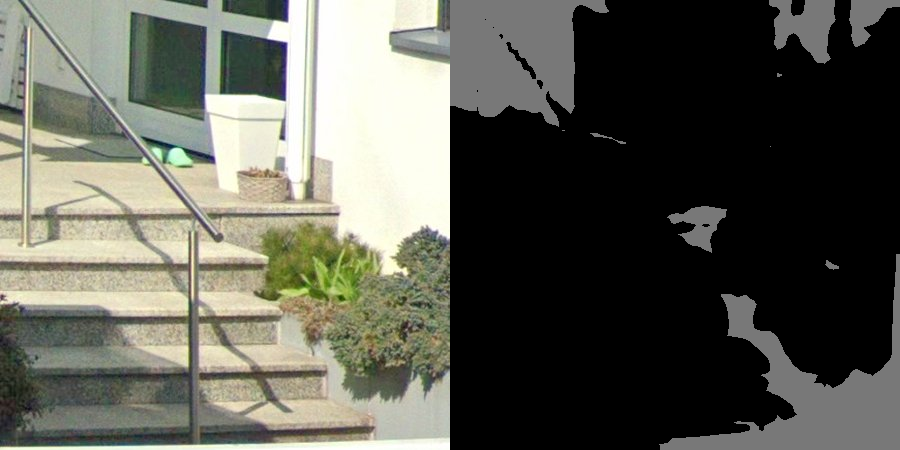

floor:


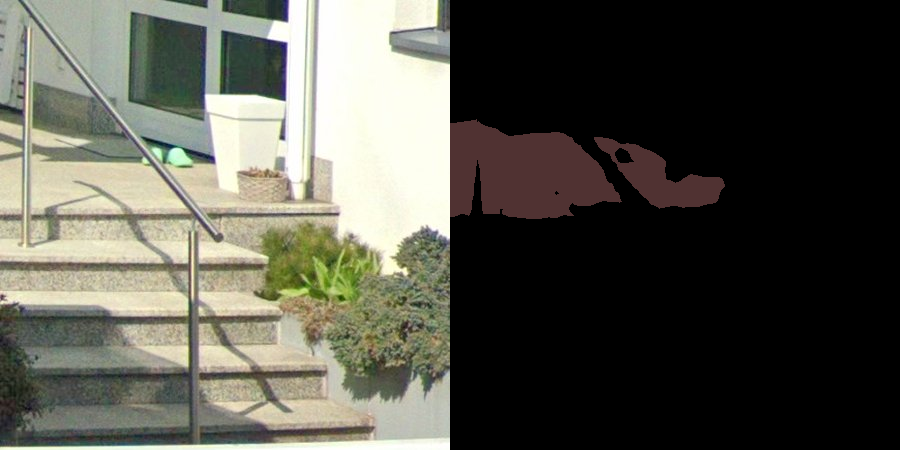

plant:


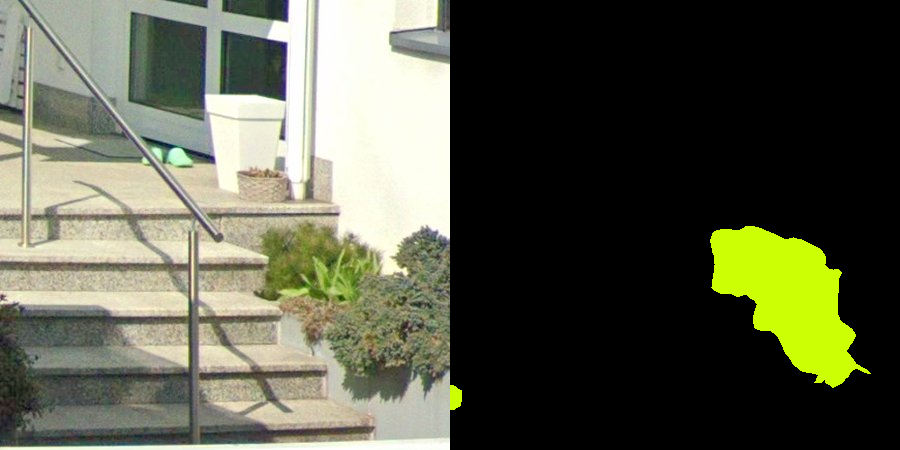

In [485]:
# Top 5 classes in answer
predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
for c in predicted_classes[:5]:
    visualize_result(img_original, pred, c)

# Now that we know our segmentation model works let us actually solve CAPTCHAs

# We need to solve 3 types of CAPTCHAS:

- Google Recaptchas:
  - <br> <img src="https://developers.nopecha.com/static/recaptcha.png" width="600"> <br>
  - These captchas fall into two categories:
    - 3x3 images where there are 9 images within the captcha
    - 4x4 images where one image is segmented into a 4x4 grid

- Alphanumeric captchas:
  - These are outdated but still used
  -  <br> <img src="captchas/letters/2b827.png" width="600"> <br>

# Solving 3x3 Recaptchas

# Convert a 3x3 captcha image to an array of 9 images

In [486]:
def img_to_arr(img_path):
    '''
        Takes the path to a 300 by 300 image
        Returns an array of 9, 100x100 images
    '''
    image = Image.open(img_path).convert('RGB')
    # Convert the image to a numpy array
    image_array = np.array(image)
    # Split the image array into 9 100x100 sections
    sections = []
    for i in range(3):
        for j in range(3):
            section = image_array[i*100:(i+1)*100, j*100:(j+1)*100]
            sections.append(section)
    # Convert the sections list to a numpy array
    sections_array = np.array(sections)
    return sections_array

# Solve 3x3 captcha

In [487]:
def solve_3_x_3(img_path, target_name, confidence, debug=False):
    '''
        Solves a 3x3 recaptcha image.
        img_path: The path to the image to solve.
        target_name: The name of the target class. E.g. "stairs" Target class should be in the 150 classes of the MIT dataset.
        confidence: The confidence threshold. The function will append 'True' if the target class is within the top 'confidence' predictions.
        debug: If True, will visualize the predictions for each square.

        Returns 
            pred_df: A dataframe of the predictions for each square.
            output_list: A list of booleans. True if the target class is in the top 'confidence' predictions for that square. False otherwise.
    '''

    # Define the transformation to apply to each image
    pil_to_tensor = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
            std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ])

    # Define the output list to return
    output_list = []
    # Define the dictionary of predictions to return
    pred_dict = {}

    img_array = img_to_arr(img_path)
    # Iterate over each image in the array
    enumerate(img_array)
    for idx, img in enumerate(img_array):
        # Convert the image to a tensor and apply the transformation
        pil_image = PIL.Image.fromarray(img)
        img_data = pil_to_tensor(pil_image)
        singleton_batch = {'img_data': img_data[None].cpu()}

        # Run the segmentation model on the image
        with torch.no_grad():
            scores = segmentation_module(singleton_batch, segSize=img_data.shape[1:])
        _, pred = torch.max(scores, dim=1)
        pred = pred.cpu()[0].numpy()

        # Visualize the predictions
        if debug:
            visualize_result(img, pred)

        # Check if the target class is present in the image
        target_class = -1
        for i in range(len(names)):
            if names[i+1] == target_name:
                target_class = i
                break
        if target_class == -1:
            raise ValueError('Target class not found in the class names.')
        
        top_preds = np.argsort(np.bincount(pred.flatten()))[::-1][:confidence]
        top_classes = [names[i+1] for i in top_preds]
        is_present = target_class in top_preds
        
        output_list.append(is_present)
        pred_dict[idx] = {'preds': top_classes}
        
    pred_df = pd.DataFrame(pred_dict)
    return output_list, pred_df


# Visualize 3x3 CAPTCHA solving

In [488]:
input_img = 'captchas/recaptcha/rc-image-tile-33/cars_8.png'
output_list, pred_df = solve_3_x_3(img_path=input_img, target_name='car', confidence=5)
print(output_list)
pred_df

[True, False, True, True, False, True, False, False, True]


,0,1,2,3,4,5,6,7,8
preds,"[road, car, person, building, wall]","[building, road, sidewalk, sky, person]","[building, tree, sky, road, car]","[car, building, grass, sky, floor]","[sky, building, tree, road, signboard]","[road, building, car, sidewalk, grass]","[sky, building, pole, tree, traffic]","[sky, building, earth, tree, road]","[sky, road, building, tree, car]"


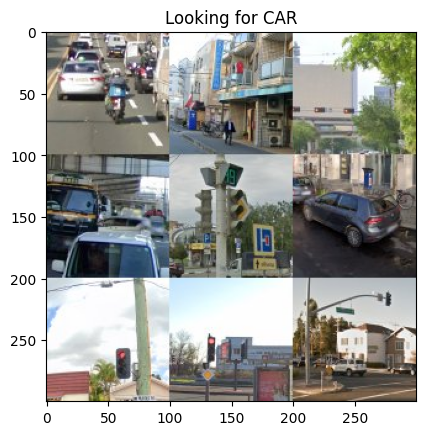

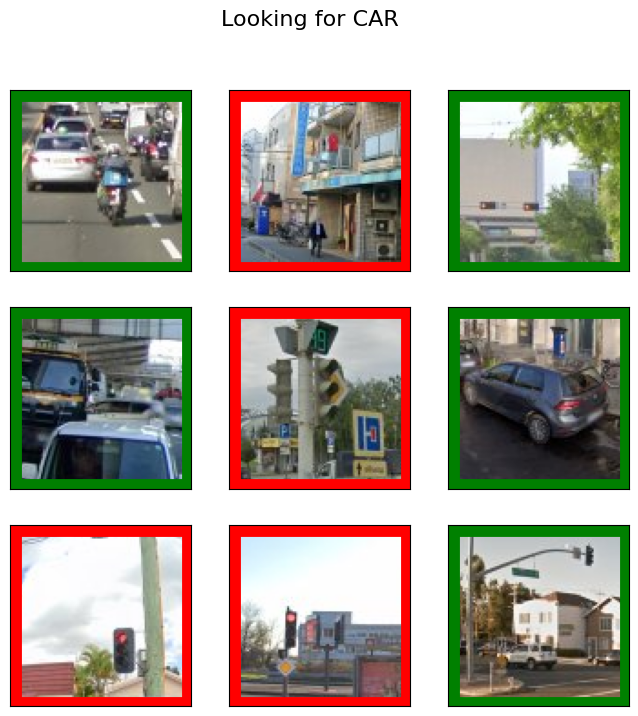

In [489]:
plt.imshow(Image.open(input_img))
plt.title("Looking for CAR")
plt.show()
array_img = img_to_arr(input_img)
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Looking for CAR', fontsize=16)
for i, axi in enumerate(ax.flat):
        axi.imshow(array_img[i])
        if output_list[i]:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='g', facecolor='none'))
        else:
            axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='r', facecolor='none'))
        axi.set(xticks=[], yticks=[])
plt.show()